## Multi-label prediction with Planet Amazon dataset

In [11]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
from fastai import *
from fastai.vision import *

## Getting the data

Min. 36 in video:
    - kaggle 10% means typically 'you know what you are doing' ;-)
    

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course-v3.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [3]:
# ! pip install kaggle --upgrade

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal).

In [4]:
## control / with having several lines marked
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [13]:
##Config.

In [14]:
path = Config.data_path()/'planet'
path.mkdir(exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/planet')

In [ ]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip` in your terminal).

In [ ]:
# ! conda install -y -c haasad eidl7zip

And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

In [ ]:
# ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [15]:
## data frame with panda
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Min, 43:30: so far we used factory methods ... create this kind pf data from this kind of source with options abc
Problem: often, we want more flexibility because there are so many variations
fast.ai: data_block: all separations separate
- Planet
- imagie file
- folder
- labelled with csv
- suffix
- random validation set
- separator
- create data sets
- transformations
- databunch with normalisation with statistics

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageMultiDataset` (and not `ImageClassificationDataset`). This will make sure the model created has the proper loss function to deal with the multiple classes.

Min. 44:50
Class AttributeError: type object 'Config' has no attribute 'data_path'
:
- part of pytorch
- doesnt do a lot! ;-)
- __getitem__(self,index) --> you cn index it with o[3]
- __len__(self
- ... dunder -->  https://www.geeksforgeeks.org/dunder-magic-methods-python/
- fast.ai does this getitem and len for many different types of data like images

Dataloader from pyotorch
- takes  dataset in construtor (so can take 3,5, or 9th item
- grabs items at random 
- size your choice
- and combines in minitbatch
- places on GPU

Databunch from fastai: Validation set
- we need a validationset to test

In [7]:
##Dataset?
##DataBunch?

In [16]:
## we use Data Bunch for modelling
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
## transforms flips randomly left to right per default
## flip_vert is fine for weather data, even more (8 ...)
## perspective warping --> look from below or from above, fast.ai specialty

Now we create the Dataset

In [17]:
np.random.seed(42)
src = (ImageFileList.from_folder(path)            
       .label_from_csv('train_v2.csv', sep=' ', folder='train-jpg', suffix='.jpg')  
       .random_split_by_pct(0.2))

Find example usages here: https://docs.fast.ai/data_block.html

You can check also the notebooks, as the fast.ai is always created from notebooks: https://github.com/fastai/fastai_docs/tree/master/dev_nb

In [18]:
src.datasets?

In [19]:
data = (src.datasets()
        ## this model gets good at 128 x 128 models. How to get it be good at 256 x 256?
        ## use transfer learning:
          ## start with this 128 x 128
        .transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

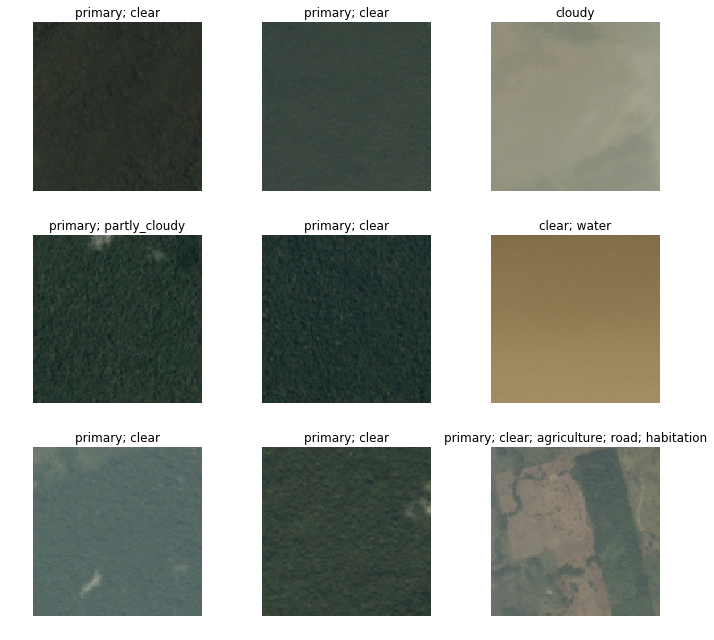

In [20]:
data.show_batch(rows=3, figsize=(10,9))

In [27]:
## databunch has a special attribute c, it is about how many outputs
data.c ## c: how many outputs, probabilities per class = length (data.classes)
## now we pick n of these probabilities and we do that by defining a treshold. 
## compare each probability to a treshold, here e.g. we compare to .2
len(data.classes)

17

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet34 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the one that are above a certain threshold (0.5 by default) and comapre them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [28]:
arch = models.resnet50

In [29]:
models.resnet50?

In [30]:
accuracy??

## uses argmax

In [ ]:
##accuracy_tresh(...,thresh=), see partial below


In [31]:
f_score = partial(fbeta, thresh=0.2)## python 3 has a so called partial. we customise that
learn = create_cnn(data, arch, metrics=[accuracy_thresh, f_score])## data, architecture
## Note: a metric has nothing to do with how the model trains
## metrics are just being used to print during training
## want to know accuracy and how would do at kaggle
## f_score: kaggle matrix, classifier has false positive & negatives. f_score combines that f1,f2 ... -->f_beta = 2

In [32]:
## f_beta()

We use the LR Finder to pick a good learning rate.

In [33]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


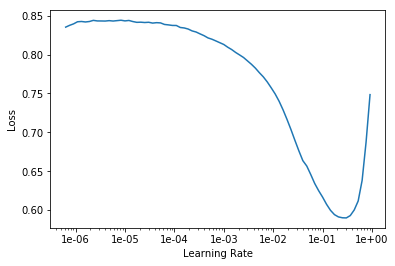

In [34]:
learn.recorder.plot()

Then we can fit the head of our network.

In [35]:
lr = 0.01

In [36]:
learn.fit_one_cycle(5, slice(lr))

Total time: 09:03
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.117184    0.105642    0.959706         0.908137  (01:49)
2      0.106278    0.104142    0.960913         0.907897  (01:47)
3      0.097718    0.091580    0.964546         0.922439  (01:48)
4      0.091459    0.086764    0.966559         0.924702  (01:48)
5      0.088415    0.085008    0.967293         0.927230  (01:48)



In [37]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

1:14:30

client side

In [38]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


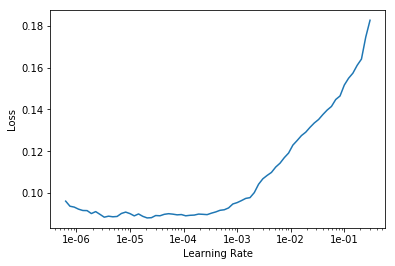

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 11:51
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.094268    0.089007    0.965578         0.922324  (02:21)
2      0.093488    0.088773    0.965367         0.926370  (02:22)
3      0.090492    0.085946    0.966493         0.926561  (02:22)
4      0.084299    0.082751    0.967431         0.929333  (02:22)
5      0.081422    0.082185    0.968209         0.929630  (02:22)



In [41]:
learn.save('stage-2-rn50')

In [43]:
## CORRECTLY DESCRIBED? 1:12:35
## we take the 128 trained model as source and fine tune (transfer learning) for the 256 case

data = (src.datasets(ImageMultiDataset)
        .transform(tfms, size=256) ## transform with same transformer as before
        .databunch().normalize(imagenet_stats))

## we replace the data in my model with this new databunch
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [44]:
## we freeze, so train just the last few layers
learn.freeze()

In [45]:
learn.lr_find()
learn.recorder.plot()

RuntimeError: CUDA error: out of memory

In [46]:
lr=1e-2/2 ## well before it 'shoots up' Note the lr graph is different because it uses a pre-trained model

In [47]:
## froze, so train last few layers
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta


RuntimeError: CUDA error: out of memory

In [ ]:
learn.save('stage-1-256-rn50')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 18:23
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.083591    0.082895    0.968310         0.928210  (03:41)
2      0.088286    0.083184    0.967424         0.928812  (03:40)
3      0.083495    0.083084    0.967998         0.929224  (03:40)
4      0.080143    0.081338    0.968564         0.931363  (03:40)
5      0.074927    0.080691    0.968819         0.931414  (03:41)



In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

## fin

(We'll look at this section later - please don't ask about it just yet! :) )

In [ ]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
# ! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}

 99%|███████████████████████████████████████▋| 599M/603M [00:11<00:00, 88.6MB/s]
100%|████████████████████████████████████████| 603M/603M [00:11<00:00, 53.2MB/s]


In [ ]:
learn.load('stage-2-256-rn50')

In [ ]:
learn.data = (src.add_test_folder('test-jpg')
        .datasets(ImageMultiDataset)
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))